# Image tiling

# HOWARD
1. Please try installing the forked image_bbox_tiling package as follows:
`pip install git+https://github.com/jcpayne/image_bbox_tiler@master`
2. I haven't made a set of sample directories for files, but for input I would just put a few images in a folder and the corresponding xml annotation files in another folder, and then point the program to it as shown below.

If the installation doesn't work then I've done something wrong, and the best bet is to download the directory and then use the hack in the next cell to put the code somewhere useful.

In [1]:
#This is a hack; I have modified a package called "image_bbox_slicer" and here I add the 
#directory containing the modified code to my search path so I can import the modified package.
import sys
# insert at position 1, because 0 is the script path (or '' in REPL)
sys.path.insert(1, '/home/howard/.../image_bbox_tiler')

In [2]:
from pathlib import Path
from pascal_voc_writer import Writer
from PIL import Image
from torchvision.transforms.functional import pad as tvpad
import random
import pdb
from image_bbox_tiler import image_bbox_slicer as ibs
import re #regex

## Goal of this notebook
Our ultimate goal is to train an AI model to detect small features (animals) in large images (aerial photographs).  The relatively poor quality of the aerial images means that we can't afford to reduce the image resolution without losing the features we want to detect.  This is generically called a "small-object detection" problem and is an active area of research.  The way the problem is generally handled is to cut large images into smaller 'tiles'.

The images are roughly 6000 x 4000 pixels and we plan to use a tile size of 500 x 500, which means we will have 12 x 8 = 96 tiles per image, i.e., roughly 100 times as many tiles as images.  Even in the training images that contain objects of interest, the objects usually fall in just a few tiles.  For training purposes, there is no benefit to feeding the model vast numbers of empty tiles, but the model may generalize better if _some_ empty tiles are included in the training data.  Tiling images also requires that the corresponding bounding box annotations must be chopped up appropriately (transforming coordinates and preserving information about the class, attributes, etc.), and introduces the problem of boxes that fall across boundaries between tiles.  

**The specific goals of this notebook were:**
1. To make sure that all images (including empty ones) have annotation files;
2. To cut the images into tiles, and to tile the corresponding bounding boxes appropriately;
3. To allow overlap between tiles to ameliorate the problem of bounding boxes that fall on tile boundaries;
4. To omit most empty tiles and to save CPU cycles by not processing them, but allow some fraction of them to be sampled at random; and
5. To make it possible to discard tiles or change the label to "none" based on a threshold for minimum bounding box area.

In [3]:
#Set filepaths
imagepath = Path('/cdata/tanzania')
im_src = str(imagepath/'temp/images') #images for input
an_src = str(imagepath/'temp/annotations') #annotation files for input
im_dst = str(imagepath/'temp/tiled_images')  #image output
an_dst = str(imagepath/'temp/tiled_annotations') #annotation output

## Fill in missing annotation files for 'empty' images
The image_bbox_tiler package expects files to be in one folder, annotations in another (the .PASCAL-VOC files should be unzipped), and then will output tiles and tile annotations into two other folders. Assuming that is set up, then the workflow is:

1. Create list of image filenames without the .jpg suffix
2. Create list of xml filesnames without the .xml suffix
3. Compare the lists
4. Use pascal_voc_writer to create an xml annotation file with no box for any missing file (need to calculate image size to do it)

In [4]:
#1. Get list of filepaths for images
p = Path(im_src)
imgs = [f for f in p.glob("*")]
imgs[1],len(imgs)

(PosixPath('/cdata/tanzania/temp/images/TA25-RKE-20191128A_R_4046.jpg'), 140)

In [5]:
#2. Get list of annotated images (note we search 'an_src', but we add the path from 'img_src' to the filename)
p = Path(an_src)
ann_raw = [Path(im_src)/f for f in p.glob("*")]
ann_raw[1],len(ann_raw)

(PosixPath('/cdata/tanzania/temp/annotations/TA25-RKE-20191128A_L_4798.xml'),
 140)

In [6]:
#3. Calculate the missing annotations by subtracting annotations from files (change suffix to jpg for annotations)
missing_ann = list(set(imgs) - set([(Path(im_src)/f.stem).with_suffix('.jpg') for f in ann_raw]))
assert (len(missing_ann)==(len(imgs) - len(ann_raw))), 'imgs - ann_raw != missing_ann'
len(missing_ann)

0

In [7]:
#4. Use pascal_voc_writer to create a new empty annotation file for each image that was missing one
if(len(missing_ann) > 0):
    nc = 0
    for img in missing_ann:
        im = Image.open(img)
        width, height = im.size
        writer = Writer(img, width, height) # Writer(path, width, height)
        #Optionally add bounding boxes:
        #::addObject(name, xmin, ymin, xmax, ymax)
        #writer.addObject('cat', 100, 100, 200, 200)    
        writer.save((Path(an_src)/img.stem).with_suffix('.xml'))
        nc +=1
    print("Created" + nc + "new annotation files")

## Tile the images
For this step, I forked a Python package called **'image_bbox_slicer'** and named the new package **'image_bbox_tiler'** to make it distinguishable for import.  The main changes made were:
1. The original package discarded any pixels that fall outside an even multiple of the tile size.  That wastes a lot of data if the tiles are large.  Each image is now padded with zeros out to an even multiple of tile size _before_ tiling it so no data is lost, and the padding works correctly if the images are of different sizes.  
2. The tile overlap math, tile size calculations, and row and column indexes were fixed to make them precisely correct (instead of various rough approximations, truncations, etc.);
3. Fixed a problem with float values in annotations that caused a display error;
4. Built in the capability to sample a variable proportion of empty tiles;
5. Revamped tile naming so that tiles are named with row and column indexes to make future reassembly easier.
6. Modified the code so tiles that are not saved are not created in the first place, to save memory and CPU cycles;
7. Made the tiled images display in the correct row and column relative to the original image, and to show padding (the placement of tiles in the original package was approximate, relative to the source image).

In [8]:
#TEMPORARY: set paths to "test2" directory
im_src = str(imagepath/'test2/images') #'./src/images'
an_src = str(imagepath/'test2/annotations') #'./src/annotations'

In [9]:
#Instantiate the slicer
slicer = ibs.Slicer()
slicer.config_dirs(img_src=im_src, ann_src=an_src,img_dst=im_dst, ann_dst=an_dst)

In [10]:
#Configure the slicer
slicer.ignore_empty_tiles = True #Discards empty tiles, EXCEPT that if sample_empty > 0 it will sample the empties anyway.
slicer.keep_partial_labels = True #Does not discard bboxes that cross tile boundaries
slicer.save_before_after_map = True #Writes a csv file with filename/tilenames

#NOTE:
#tile_overlap: float (percentage of tile overlap between two consecutive strides).
#I'm setting to 0.01 ~= 50px/6000px (50/4000 = .0125)
#Image 1 is
#Image 2 is (6490, 4510) pixels

In [18]:
#Slice away!
slicer.slice_by_size(tile_size=(500,500), tile_overlap=0.05,empty_sample=.5)

Obtained 125 annotation slices!
Successfully saved the mapping between files before and after slicing at /cdata/tanzania/temp/tiled_annotations
Obtained 125 image slices!
Successfully saved the mapping between files before and after slicing at /cdata/tanzania/temp/tiled_images


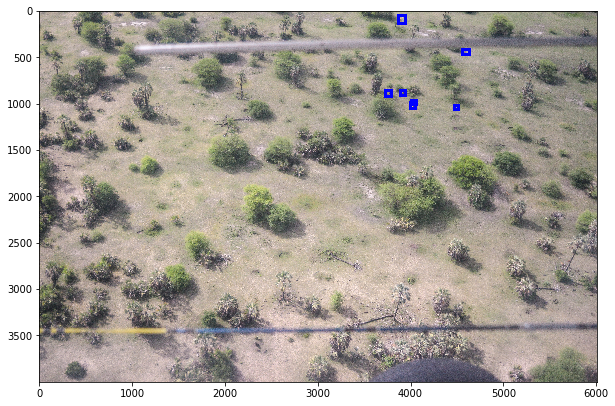

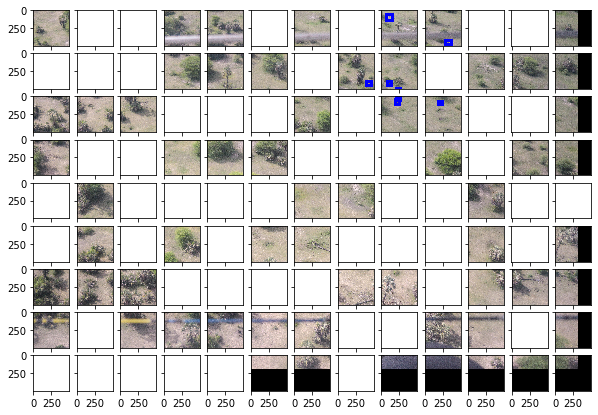

In [22]:
#Pick an image and its tiles at random (BE PATIENT -- the tiled matrix is very slow to render)
slicer.visualize_sliced_random()

# Code scraps (alternative methods, etc.)

## libvips (which has a Python wrapper called pyvips)
The library is designed for working with very large images without blowing out RAM; it's fast and streamlined.  But libvips does not have a perfect tiling function; instead the author recommends the `dzsave` function, which is designed for making image pyramids for tiled imagery.
The author answered some of my questions on StackExchange: 
1. Tile names are in the form `column_row.tif` if you save to the deepzoom format; 
2. "`dzsave` outputs deepzoom / google maps / zoomify / iiif pyramids, so you get a choice from those naming conventions. 
3. "Overlaps are just pixels that are shared between tiles, so eg. with overlap 1, the rightmost two columns in tile 0_0 are identical to the leftmost two column in tile 1_0. Set overlap to 0 if you want non-overlapping tiles."
https://libvips.github.io/libvips/API/current/Making-image-pyramids.md.html

```bash
vips dzsave hugefile.tif outdir --depth one --tile-size 512 --overlap 0 --suffix .tif
    --depth one #slices a large image into tiles, rather than making a pyramid.
    overlap #Tile overlap in pixels--warning: input parameter 'gint' has a default of 1!
    --background 0 #black
```

Comparing libvips to ImageMagick, libvips seems faster:

In [27]:
# $ time convert -crop 512x512 +repage huge.tif x/image_out_%d.tif
# real    0m5.623s
# user    0m2.060s
# sys     0m2.148s
# $ time vips dzsave huge.tif x --depth one --tile-size 512 --overlap 0 --suffix .tif
# real    0m1.643s
# user    0m1.668s
# sys     0m1.000s

More libvips code examples

In [28]:
# import pyvips

# image = pyvips.Image.new_from_file('some-image.jpg', access='sequential')
# image *= [1, 2, 1]
# mask = pyvips.Image.new_from_array([[-1, -1, -1],
#                                     [-1, 16, -1],
#                                     [-1, -1, -1]
#                                    ], scale=8)
# image = image.conv(mask, precision='integer')
# image.write_to_file('x.jpg')

ImageMagick code for tiling **and renaming tiles by row and column**

In [ ]:
magick hugeimage.png -crop 256x256 -set filename:f "tile_%[fx:page.x],%[fx:page.y]_%[w]x%[h]" "%

...and lastly, **a custom method for reducing the memory impact when using ImageMagick**.

In [ ]:
# #This version puts row and col in the filename (good for reassembly!).  Trick is to divide coordinate by cropsize.  
# #He added 1001 instead of 1 to get constant-width numbers in the output. Nice!
# #!/bin/bash
# /usr/bin/convert bigimage.jpg -crop 256x256 \
#   -set filename:tile "%[fx:page.x/256+1001]_%[fx:page.y/256+1001]" \
#     +repage +adjoin "tiled_%[filename:tile].jpg"
    
# convert -verbose images\0.png -crop 256x256 +adjoin -background white -extent 256x256 -set filename:tile "%%[fx:floor(page.x/256)]_%%[fx:floor(page.y/256)]" +repage "tiles\0_%%[filename:tile].png"

# #OR a 3-step method:
# #1. convert to mpc (ImageMagick's native format)
# convert -monitor -limit area 2mb myLargeImg.tif myLargeImg.mpc
# #2. Bash program (potentially useful anyway)
# #!/bin/bash
#  src=$1
#  width=`identify -format %w $src`
#  limit=$[$width / 256]
#  echo "count = $limit * $limit = "$((limit * limit))" tiles"
#  limit=$((limit-1))
#  for x in `seq 0 $limit`; do
#    for y in `seq 0 $limit`; do
#      tile=tile-$x-$y.png
#      echo -n $tile
#      w=$((x * 256))
#      h=$((y * 256))
#      convert -debug cache -monitor $src -crop 256x256+$w+$h $tile
#    done
#  done

# #3. call the bash program
#  sh ./tiler.sh myLargeImg.mpc
    